In [1]:
from IPython.display import Image

# 6장 모델 평가와 하이퍼파라미터 튜닝의 모범 사례 

## 6.1 파이프라인을 사용한 효율적인 워크플로 

### 워스콘신 유방암 데이터셋 

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
le.transform(['M', 'B'])

array([1, 0])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

### 파이프라인으로 변화기와 추정기 연결

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [8]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(random_state=1))

In [9]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [10]:
from sklearn import set_config

set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [11]:
Image(url='https://git.io/JtsTr', width=500)

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가 

### 홀드아웃 방법 

In [12]:
Image(url='https://git.io/JtsTo', width=500)

### k-겹 교차 검증 

In [13]:
Image(url='https://git.io/JtsT6', width=500)

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kford = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kford):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k + 1, np.bincount(y_train[train]), score))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956


In [15]:
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV 정확도: 0.950 +/- 0.014


In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print('CV 정확도 점수: %s' % scores)
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV 정확도: 0.950 +/- 0.014


In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr,
                       X=X_train,
                       y=y_train,
                       scoring=['accuracy'],
                       cv=10,
                       n_jobs=-1)

print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV 정확도: 0.950 +/- 0.014


In [18]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)

preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [19]:
preds = cross_val_predict(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         method='predict_proba',
                         n_jobs=-1)

preds[:10]

array([[9.93982352e-01, 6.01764759e-03],
       [7.64328337e-01, 2.35671663e-01],
       [9.72683946e-01, 2.73160539e-02],
       [8.41658121e-01, 1.58341879e-01],
       [9.97144940e-01, 2.85506043e-03],
       [9.99803660e-01, 1.96339882e-04],
       [9.99324159e-01, 6.75840609e-04],
       [2.12145074e-06, 9.99997879e-01],
       [1.28668437e-01, 8.71331563e-01],
       [7.76260670e-04, 9.99223739e-01]])

## 6.3  학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅 

### 학습 곡선으로 편향과 분산 문제 분석

In [20]:
Image(url='https://git.io/JtsTi', width=600)

In [21]:
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2', random_state=1, max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean =np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

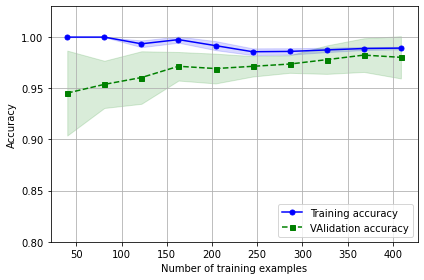

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='VAlidation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

### 검증 곡선으로 과대척합과 과소적합 조사 

In [23]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean =np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

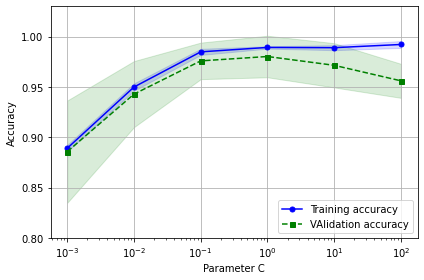

In [24]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='VAlidation accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

## 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝 

### 그리드 서치를 사용한 하이퍼파라미터 튜닝 

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 refit=True,
                 n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [26]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


In [27]:
print(np.sum(gs.cv_results_['mean_fit_time']))

1.1192165851593017


---

In [28]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 return_train_score=True,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
gs.cv_results_['split0_train_score']

array([0.6405868 , 0.93643032, 0.97555012, 0.98777506, 0.98533007,
       0.99266504, 0.99755501, 1.        , 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.62591687, 0.62591687, 0.62591687, 0.7799511 , 0.94621027,
       0.96577017, 0.62591687, 0.62591687, 0.62591687, 0.62591687,
       0.78484108, 0.94621027, 0.9804401 , 0.99266504, 1.        ,
       1.        , 1.        , 1.        , 0.94621027, 0.97799511,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97799511, 0.98777506, 0.99511002, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98533007,
       0.99266504, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [29]:
gs.cv_results_['mean_train_score']

array([0.6402928 , 0.93724074, 0.97240801, 0.98510406, 0.98803447,
       0.99145447, 0.99707019, 0.9992677 , 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.62637307, 0.62637307, 0.62637307, 0.77070249, 0.94700817,
       0.97167094, 0.62637307, 0.62637307, 0.62637307, 0.62637307,
       0.77949371, 0.94725326, 0.97704753, 0.99291848, 1.        ,
       1.        , 1.        , 1.        , 0.94652096, 0.97753354,
       0.99023257, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97680064, 0.98852287, 0.99755799, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98803387,
       0.99291848, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [30]:
gs.cv_results_['split0_test_score']

array([0.63043478, 0.89130435, 0.95652174, 0.97826087, 0.95652174,
       0.93478261, 0.95652174, 0.93478261, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.69565217, 0.93478261,
       0.95652174, 0.63043478, 0.63043478, 0.63043478, 0.63043478,
       0.69565217, 0.93478261, 0.93478261, 1.        , 0.63043478,
       0.63043478, 0.63043478, 0.63043478, 0.93478261, 0.97826087,
       1.        , 1.        , 0.63043478, 0.63043478, 0.63043478,
       0.63043478, 0.97826087, 0.97826087, 0.97826087, 1.        ,
       0.63043478, 0.63043478, 0.63043478, 0.63043478, 0.97826087,
       0.95652174, 0.95652174, 1.        , 0.63043478, 0.63043478,
       0.63043478, 0.63043478])

In [31]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.974


---

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution = loguniform(0.0001, 1000.0)
param_dist = [{'svc__C': distribution, 'svc__kernel': ['linear']},
             {'svc__C': distribution, 'svc__gamma': distribution, 'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                       param_distributions=param_dist,
                       n_iter=30,
                       cv=10,
                       random_state=1,
                       n_jobs=-1)
rs.fit(X_train, y_train)

print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


---

In [33]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

hgs = HalvingGridSearchCV(estimator=pipe_svc,
                         param_grid=param_grid,
                         cv=10,
                         refit=True,
                         n_jobs=-1, verbose=1)

hgs = hgs.fit(X_train, y_train)

print(hgs.best_score_)
print(hgs.best_params_)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 40
max_resources_: 455
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 40
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 24
n_resources: 120
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 8
n_resources: 360
Fitting 10 folds for each of 8 candidates, totalling 80 fits
0.9774603174603176
{'svc__C': 1000.0, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [34]:
print(np.sum(hgs.cv_results_['mean_fit_time']))

0.17350826263427735


In [35]:
print('자원 리스트:', hgs.n_resources_)
print('후보 리스트:', hgs.n_candidates_)

자원 리스트: [40, 120, 360]
후보 리스트: [72, 24, 8]


### 중첩 교차 검증을 사용한 알고리즘 선택

In [36]:
Image(url='https://git.io/JtsTP', width=500)

In [37]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)
scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy',
                        cv=5)

print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [38]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy',
                 cv=2)
scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy',
                        cv=5)

print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도: 0.934 +/- 0.016


## 6.5 여러 가지 성능 평가 지표 

In [39]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


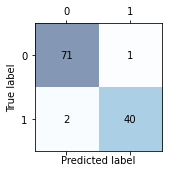

In [40]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

---

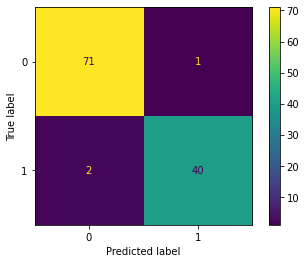

In [41]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)
plt.show()

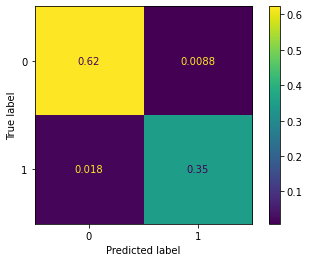

In [42]:
plot_confusion_matrix(pipe_svc, X_test, y_test, normalize='all') # 'true', 'pred'
plt.show()

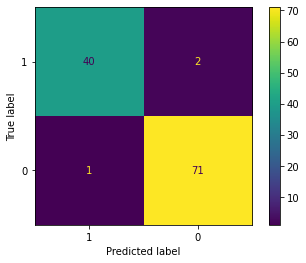

In [43]:
plot_confusion_matrix(pipe_svc, X_test, y_test, labels=[1, 0])
plt.show()

### 분류 모델의 정밀도와 재현율 최적화 

* 오차

$\;\;\;\;\;\displaystyle \text{ERR}=\frac{\text{FP + FN}}{\text{FP +FN + TP + TN}}$

* 예측 정확도

$\;\;\;\;\;\displaystyle \text{ACC}=\frac{\text{TP + TN}}{\text{FP +FN + TP + TN}}=1-\text{ERR}$

* 진짜 양성 비율(True Positive Rate, TPR)

$\;\;\;\;\;\displaystyle \text{TPR}=\frac{\text{TP}}{\text{P}}=\frac{\text{TP}}{\text{FN + TP}}$

* 거짓 양성 비율(False Positive Rate, FPR)

$\;\;\;\;\;\displaystyle \text{FPR}=\frac{\text{FP}}{\text{N}}=\frac{\text{FP}}{\text{FP + TN}}$

* 정확도

$\;\;\;\;\;\displaystyle \text{PRE}=\frac{\text{TP}}{\text{TP + FP}}$

* 재현율(REC)

$\;\;\;\;\;\displaystyle \text{REC}=\text{TPR}=\frac{\text{TP}}{\text{P}}=\frac{\text{TP}}{\text{FN + TP}}$

* F1-점수

$\;\;\;\;\;\displaystyle \text{F1}=2\frac{\text{PRE}\times\text{REC}}{\text{PRE} + \text{REC}} $

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


In [45]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range, 'svc__kernel': ['linear']},
            {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### ROC(Receiver Operating Characteristic) 곡선 그리기 

In [46]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

In [47]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=1, C=100.0))

X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train))

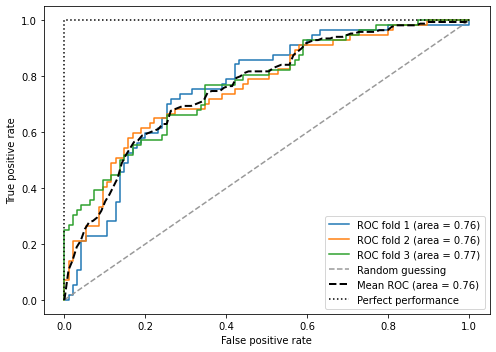

In [48]:
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0, 1], [0, 1], ls='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], ls=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

---

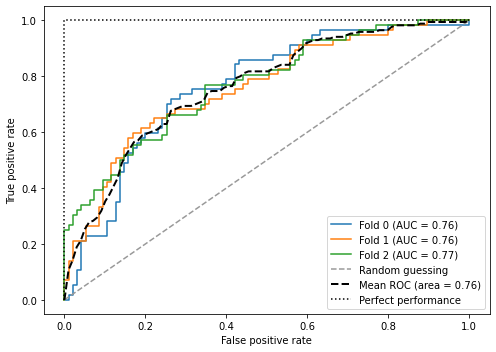

In [49]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = plot_roc_curve(pipe_lr,
                             X_train2[test], y_train[test],
                             name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0
    
plt.plot([0, 1], [0, 1], ls='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], ls=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

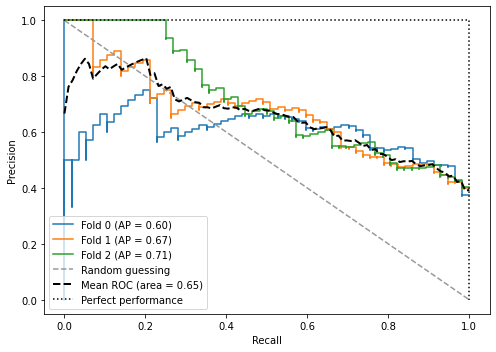

In [50]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)
for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = plot_precision_recall_curve(pipe_lr,
                             X_train2[test], y_train[test],
                             name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], pr_disp.precision[::-1])
    
plt.plot([0, 1], [1, 0], ls='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0], ls=':', color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### 다중 분류의 성능 지표 

\begin{align*}
\text{PRE}_{micro}  &= \frac{\text{TP}_1 + \cdots + \text{TP}_k}{\text{TP}_1 + \cdots + \text{TP}_k +\text{FP}_1 + \cdots + \text{FP}_k}
\\ 
\text{PRE}_{macro} &= \frac{\text{PRE}_1 + \cdots + \text{PRE}_k}{k} 
\end{align*}

In [51]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')  # 디폴트는 macro임

## 6.6 불균형 클래스 다루기

In [52]:
X_imb = np.vstack((X[y==0], X[y==1][:40])) # 불균일한 데이셋
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [53]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred==y_imb) * 100

89.92443324937027

In [54]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb==1].shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40


In [55]:
X_upsampled, y_upsampled = resample(X_imb[y_imb==1], y_imb[y_imb==1],
                                   replace=True,
                                   n_samples=X_imb[y_imb==0].shape[0],
                                   random_state=123)
print('샘플링한 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링한 후 클래스 1의 샘플 개수: 357


In [56]:
x_bal = np.stack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

In [57]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred==y_bal) * 100

50.0